# Notebook 1.5 - Advanced simulation

In this notebook we will illustrate more advanced simulation case,
especially: 

- time dependant stimulus
- burn-in

Let's create a network for our model and following [bursty](../api/harissa.simulation.bursty_pdmp.base) simulations.
We will use one of the network of the [notebook 3](./notebook3.ipynb).

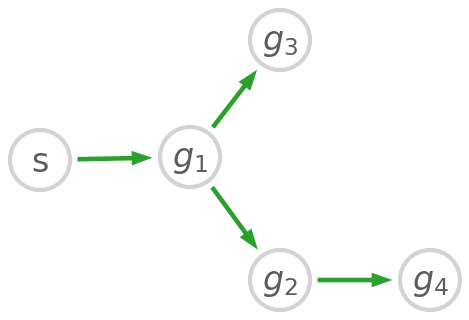

In [54]:
import numpy as np
from harissa import NetworkParameter, NetworkModel
from harissa.simulation import BurstyPDMP
from harissa.plot import plot_network

param = NetworkParameter(4)

param.degradation_rna[:] = 1.0
param.degradation_protein[:] = 0.2
param.burst_frequency_min[:] = 0.0 * param.degradation_rna
param.burst_frequency_max[:] = 2.0 * param.degradation_rna
param.creation_rna[:] = param.degradation_rna * param.rna_scale()
param.creation_protein[:]=param.degradation_protein * param.protein_scale()
param.basal[1:] = -5.0
# param.basal[3] = 2.0
param.interaction[0, 1] = 10.0
param.interaction[1, 2] = 10.0
param.interaction[1, 3] = 10.0
param.interaction[2, 4] = 10.0

param.gene_names = np.array(['s', '$g_1$', '$g_2$', '$g_3$', '$g_4$'])
param.layout = np.array([[-0.6,0],[-0.1,0.01],[0.2,-0.4],[0.2,0.4],[0.7,-0.4]])

plot_network(param.interaction, param.layout, scale=3, names=param.gene_names)

model = NetworkModel(parameter=param, simulation=BurstyPDMP(use_numba=True))


TODO: interpretation of the network

Let's do a default simulation during 100 units.
Since no other arguments are give to the `simulate` function, 
the simulation start at the time 0 and the rna and proteins levels also starts at zero.
Moreover the stimulus is fully activated and constant.

See the [API documentation](../api/harissa.core.model) for more information.

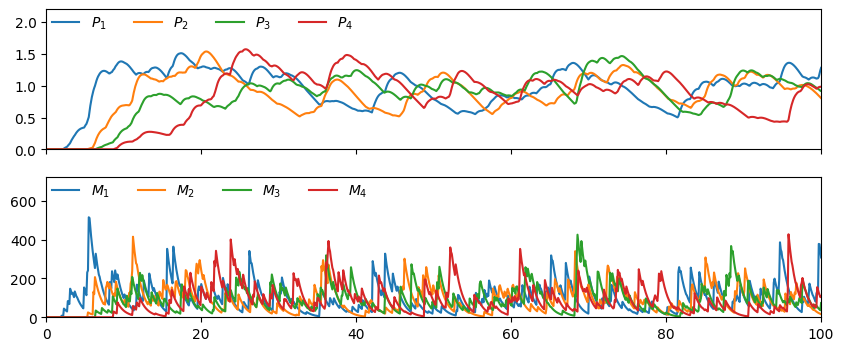

In [55]:
from harissa.plot import plot_simulation

time_points = np.linspace(0.0, 100.0, 1000)
simulation_result = model.simulate(time_points)

plot_simulation(simulation_result).show(warn=False)

## Visualize stimulus

To visualize the stimulus trajectory over time, 
you need to put the argument `plot_stimulus` at `True` 
in the `plot_simulation` function.

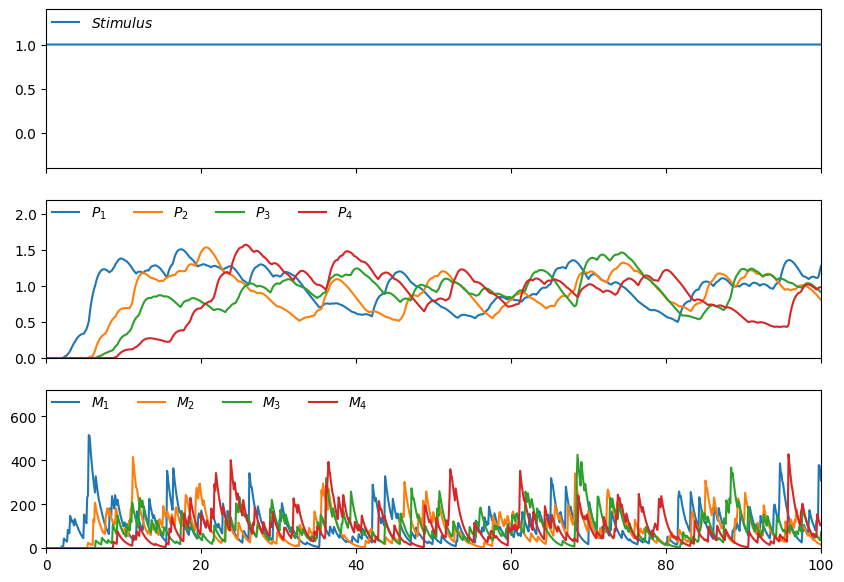

In [56]:
plot_simulation(simulation_result, plot_stimulus=True).show(warn=False)

## Time dependent stimulus

Let's have a stimulus that varies over time like the following.

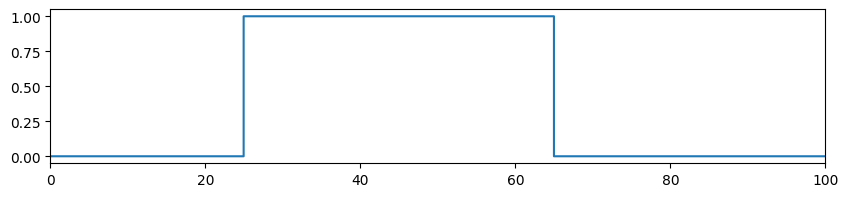

In [57]:
import matplotlib.pyplot as plt

stimulus = np.zeros(time_points.size)
stimulus[np.logical_and(time_points >= 25, time_points <= 65)] = 1.0

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.step(time_points, stimulus)
ax.set_xlim(time_points[0], time_points[-1])
fig.show(warn=False)


To do a simulation with this stimulus trajectory, you can either
do 3 simulations with a constant stimulus and then concatenate their results 
(with the operator `+`).

:::{warning}
The `+` operator is not commutative. 
The last time point of the left result must be less than 
the first time point of the right result.
:::

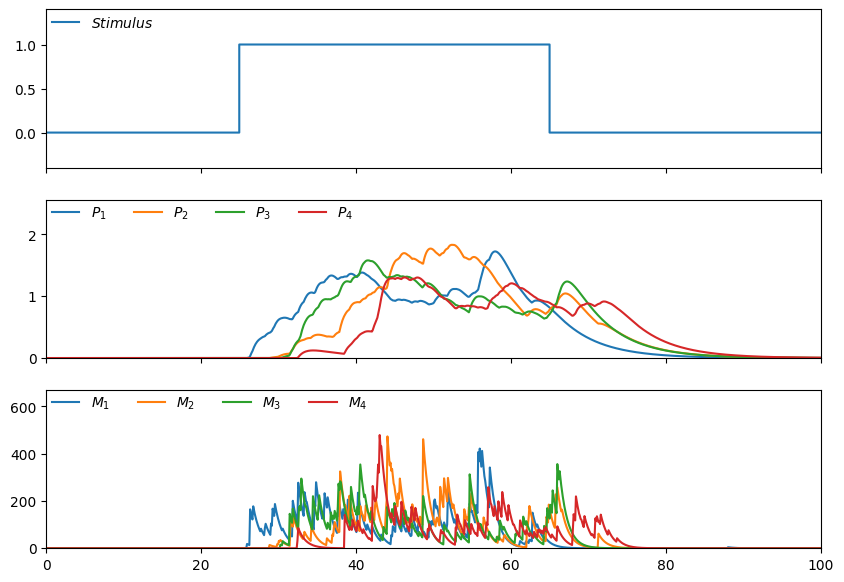

In [58]:
initial_state = np.zeros((2, param.n_genes_stim))
simulation_result = model.simulate(
    time_points[time_points < 25],
    initial_state=initial_state
)
initial_state = simulation_result.final_state
initial_state[1, 0] = 1.0
simulation_result = simulation_result + model.simulate(
    time_points[np.logical_and(time_points >= 25, time_points <= 65)],
    initial_state=initial_state,
    initial_time=simulation_result.time_points[-1]
)
initial_state = simulation_result.final_state
initial_state[1, 0] = 0.0
simulation_result = simulation_result + model.simulate(
    time_points[time_points > 65],
    initial_state=initial_state,
    initial_time=simulation_result.time_points[-1]
)
plot_simulation(simulation_result, plot_stimulus=True).show(warn=False)

Or you can use the keyword argument `stimulus` of the `simulate` function.

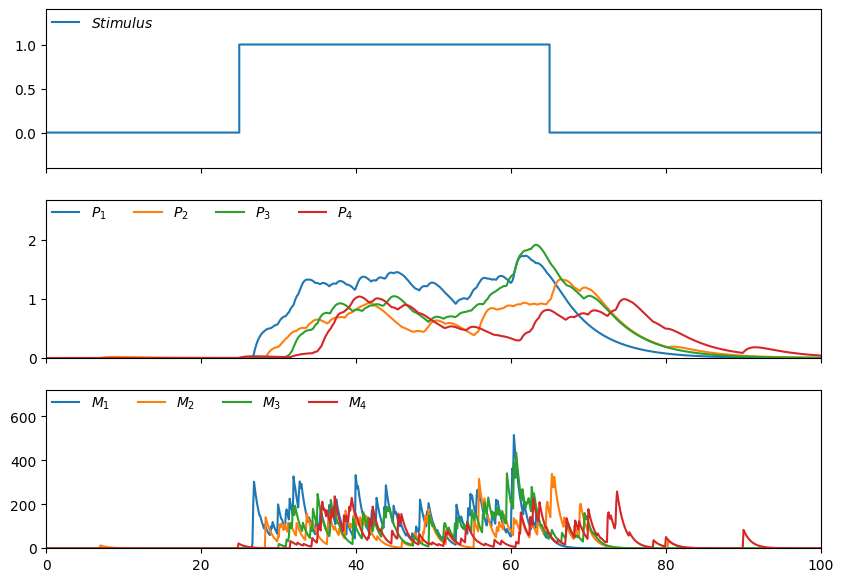

In [59]:
simulation_result = model.simulate(
    time_points,
    initial_state=np.zeros((2, param.n_genes_stim)),
    stimulus=stimulus
)
plot_simulation(simulation_result, plot_stimulus=True).show(warn=False)

`TODO`: interpretation of the plots

## Burn-in

All the rna and proteins levels of the previous simulations started at zero.
To start with non trivial values, we can have a period of **burn-in**.
We can simulate for a bit of time with a stimulus deactivated 
to reach a stationary state.

To see it better let's tweak the previous network by having a basal activity 
for the **gene 3** and having the gene 1 **inhibits** the gene 3.

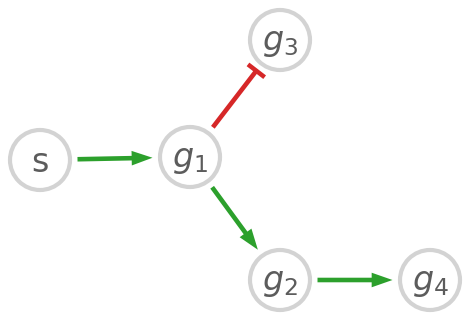

In [60]:
param.basal[3] = 5.0
param.interaction[1, 3] = -10.0
plot_network(
    param.interaction,
    param.layout,
    names=param.gene_names,
    scale=3
)

let's first look at a default simulation with this network.

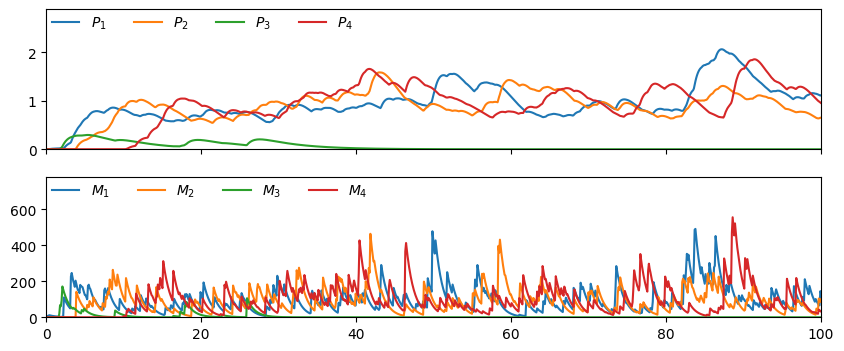

In [61]:
simulation_result = model.simulate(time_points)

plot_simulation(simulation_result).show(warn=False)

We can see that when the gene 1 is active it inhibits the gene 3 activity.
However the rna and proteins start at zero like previously and we don't see
the gene 3 should be active at the start.

To see it we can set a better initial state.
Let's use the following state given by the function `burn_in`.

In [62]:
burn_in_state = model.burn_in(50.0)

print(burn_in_state)

[[0.00000000e+00 0.00000000e+00 9.72146857e-07 4.17878101e+01
  8.76945255e-18]
 [1.00000000e+00 0.00000000e+00 1.27337475e-03 8.88216814e-01
  3.55611875e-05]]


Now let's simulate.

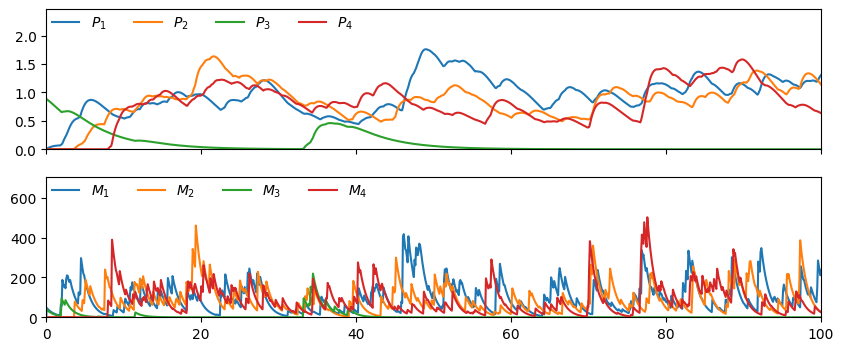

In [63]:
simulation_result = model.simulate(time_points, initial_state=burn_in_state)

plot_simulation(simulation_result).show(warn=False)


Now we can see that **gene 3** is active at the start.

:::{note}
The `burn_in` functions is equivalent to a simulation with a deactivated
stimulus that records only the final state.
For example the following simulation is equivalent to the previous simulation.
:::

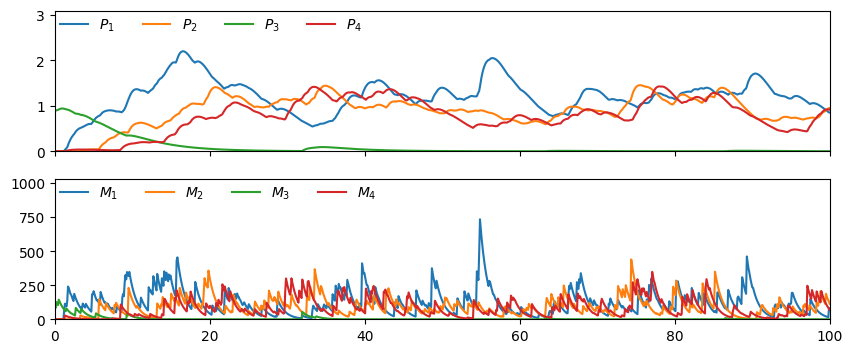

In [64]:
initial_state = np.zeros((2, param.n_genes_stim))
initial_state = model.simulate(
    np.array([50]),
    initial_state=initial_state
).final_state
initial_state[1, 0] = 1.0
simulation_result = model.simulate(time_points, initial_state=initial_state)

plot_simulation(simulation_result).show(warn=False)

### Recording the burn-in

To see the burn-in trajectory we can simulate it and recording by hand
with the following code. 

:::{note}
Here we decided that the time points of the burn-in are negative but they can also be positive.
:::

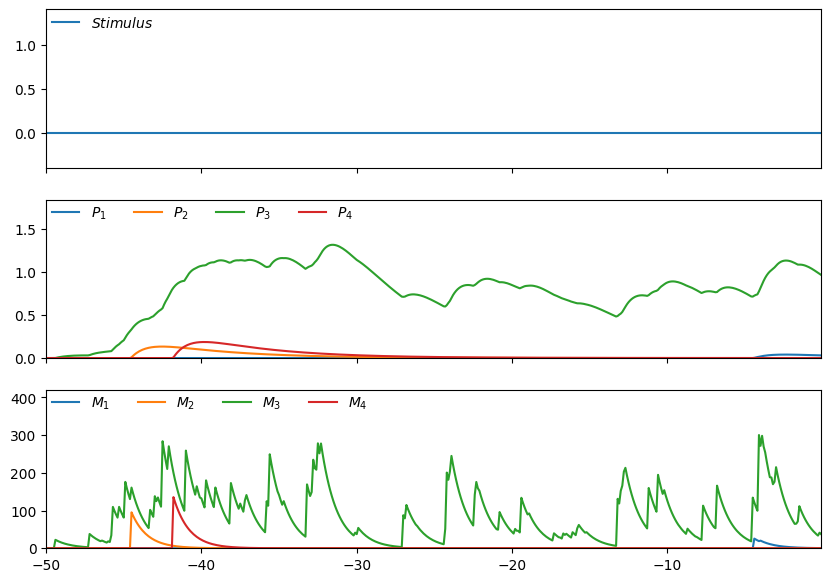

In [65]:
burn_in_time_points = np.linspace(-50, 0, 500, endpoint=False)
initial_state = np.zeros((2, param.n_genes_stim))
burn_in_result = model.simulate(
    burn_in_time_points,
    initial_time=burn_in_time_points[0],
    initial_state=initial_state
)

plot_simulation(burn_in_result, plot_stimulus=True).show(warn=False)

Now let's concatenate it to a simulation with a active stimulus and 
an initial state that is the final state of the burn-in simulation to observe
effects of the activation of the stimulus on the genes.

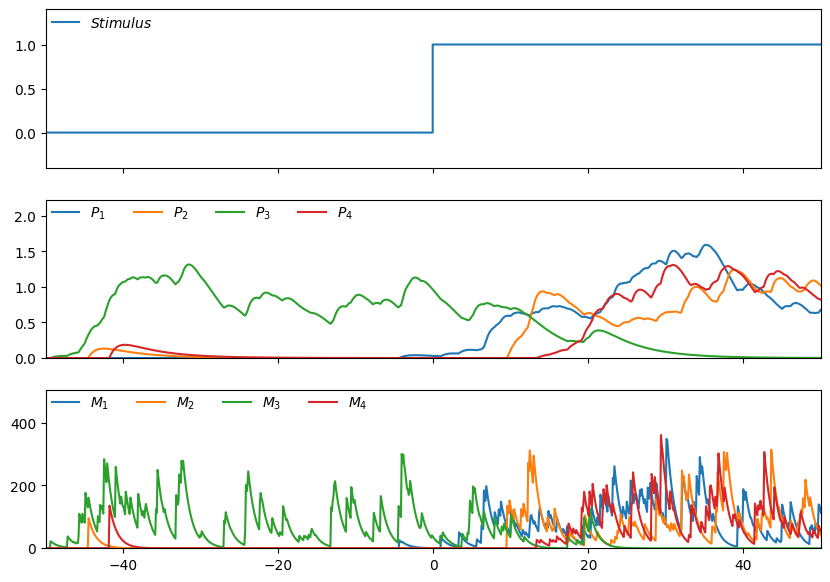

In [66]:
time_points = np.linspace(0, 50, 500)
initial_state = burn_in_result.final_state
initial_state[1, 0] = 1.0
simulation_result = model.simulate(
    time_points,
    initial_time=burn_in_time_points[-1],
    initial_state=initial_state
)

plot_simulation(
    burn_in_result + simulation_result,
    plot_stimulus=True
).show(warn=False)

Of course we can do the same thing with varying stimulus 
and the keyword argument `stimulus` of
the `simulate` function like in the previous section.

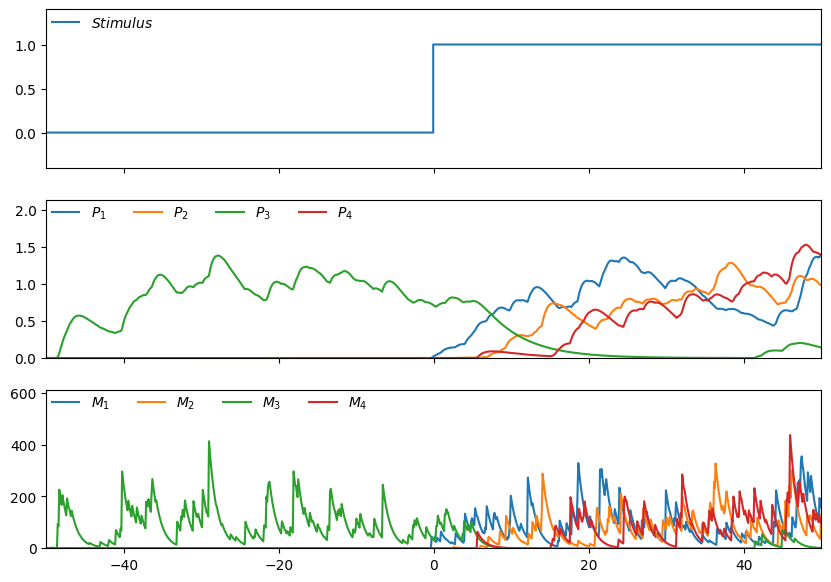

In [67]:
time_points = np.linspace(-50, 50, 1000)
initial_state = np.zeros((2, param.n_genes_stim))
stimulus = np.zeros(time_points.shape)
stimulus[time_points >= 0.0] = 1.0

simulation_result = model.simulate(
    time_points,
    initial_state=initial_state,
    initial_time=time_points[0],
    stimulus=stimulus
)

plot_simulation(simulation_result, plot_stimulus=True).show(warn=False)

## Average trajectories

The [bursty](../api/harissa.simulation.bursty_pdmp.base) model is stochastic, for example the `gene 3` can still burst even if it is
inhibited by the `gene 1`.
To make this behaviour more deterministic we can do `10000` simulations
and plot the average trajectories. 

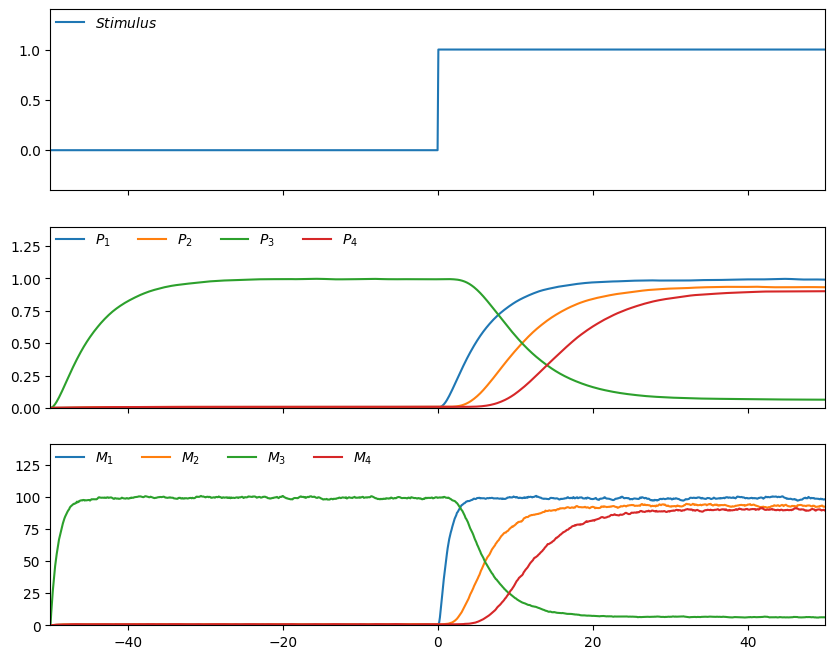

In [68]:
import matplotlib.gridspec as gridspec
nb_simulations = 10000
simulations = [
    model.simulate(
        time_points,
        initial_state=initial_state,
        initial_time=time_points[0],
        stimulus=stimulus
    ) for _ in range(nb_simulations)
]

def plot_average_simulation(simulations):
    stimulus_levels, protein_levels, rna_levels = (
        np.mean([getattr(sim, attr) for sim in simulations], axis=0)
        for attr in ['stimulus_levels', 'protein_levels', 'rna_levels']
    )
    time_points = simulations[0].time_points
    n = simulations[0].protein_levels.shape[1]

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(3, 1)
    axs = [fig.add_subplot(gs[i, 0]) for i in range(3)]

    y_scale = 1.4

    axs[0].plot(time_points, stimulus_levels, label='$Stimulus$')
    axs[0].set_xlim(time_points[0], time_points[-1])
    axs[0].set_ylim(1.0-y_scale, y_scale)
    axs[0].tick_params(axis='x', labelbottom=False)
    axs[0].legend(loc='upper left', ncol=1, borderaxespad=0, frameon=False)

    # Plot proteins
    for i in range(1, n):
        axs[1].plot(time_points, protein_levels[:,i], label=f'$P_{{{i}}}$')
    axs[1].set_xlim(time_points[0], time_points[-1])
    axs[1].set_ylim(0, y_scale * np.max([np.max(protein_levels), 1]))
    axs[1].tick_params(axis='x', labelbottom=False)
    axs[1].legend(loc='upper left', ncol=4, borderaxespad=0, frameon=False)
    # Plot mRNA

    for i in range(1, n):
        axs[2].plot(time_points, rna_levels[:,i], label=f'$M_{{{i}}}$')
    axs[2].set_xlim(time_points[0], time_points[-1])
    axs[2].set_ylim(0, y_scale * np.max(rna_levels))
    axs[2].legend(loc='upper left', ncol=4, borderaxespad=0, frameon=False)

plot_average_simulation(simulations)

Or you can use the [ode](../api/harissa.simulation.approx_ode.base) model to simulate the average trajectories of a bursty model when the number of simulations tends towards infinity.

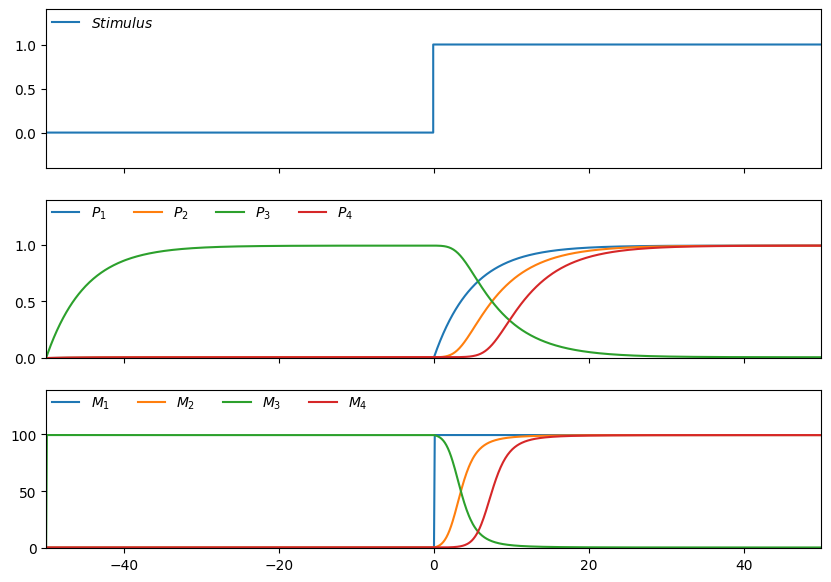

In [69]:
from harissa.simulation import ApproxODE

model.simulation = ApproxODE()
simulation_result = model.simulate(
    time_points,
    initial_state=initial_state,
    initial_time=time_points[0],
    stimulus=stimulus
)

plot_simulation(simulation_result, plot_stimulus=True).show(warn=False)